# Hate speech calassification
by Jan Boder & Jan Dorn

## Imports & read data
### TODOs

* hyperparameter optimization for NN
* normalization




In [ ]:
#imports
import pandas as pd

import numpy as np

import re

import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read training data, and test set to be predicted
data = pd.read_csv('drive/MyDrive/Colab Notebooks/train.tsv',sep='\t')

data_to_predict = pd.read_csv('drive/MyDrive/Colab Notebooks/test.tsv.dist',sep='\t')

## Basic inspection of dataset


### Training data

In [ ]:
data.head()

,text,label
0,RT @USER: when you in a public place and ya si...,NG
1,@USER he ate my pussy i could..,NG
2,"When you give somebody that ""bitch"" look",NG
3,Double Stuff Oreos mane say,OK
4,@USER lol la bitch happy bout Beatin our bench...,NG


In [ ]:
#check for missings
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18682 entries, 0 to 18681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18682 non-null  object
 1   label   18682 non-null  object
dtypes: object(2)
memory usage: 292.0+ KB


In [ ]:
data['label'].value_counts()

NG    15352
OK     3330
Name: label, dtype: int64

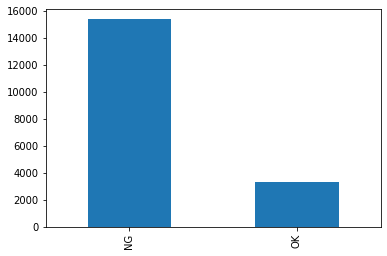

In [ ]:
data['label'].value_counts().plot(kind='bar')

### Data to be predicted

In [ ]:
data_to_predict.head()

,text,label
0,Niggas cry when they get hit high and cry when...,?
1,RT @USER: Boss Niggas Fuk wit Boss bitches Vic...,?
2,"Notice I didn't tweet ""bytches"".... Bytch is d...",?
3,@USER @USER fuck up pussy,?
4,@USER i swear u a fuck nigga u a scary little ...,?


In [ ]:
data_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4671 entries, 0 to 4670
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4671 non-null   object
 1   label   4671 non-null   object
dtypes: object(2)
memory usage: 73.1+ KB


## Preprocessing

In [ ]:
#remove @USER, RT and {{URL}}
data['text'] = data['text'].apply(lambda x: x.replace('@USER', '').replace('RT', '').replace('{{URL}}', ''))
data.head()

data_to_predict['text_custom_cleaned'] = data_to_predict['text'].apply(lambda x: x.replace('@USER', '').replace('RT', '').replace('{{URL}}', ''))


In [ ]:
#remove stopwords, non-alphabetic characters
nltk.download('stopwords')
stemmer = SnowballStemmer('english')
words = stopwords.words("english")

data['cleaned'] = data['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
data.head()

data_to_predict['cleaned'] = data_to_predict['text_custom_cleaned'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
data_to_predict.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label,text_custom_cleaned,cleaned
0,Niggas cry when they get hit high and cry when...,?,Niggas cry when they get hit high and cry when...,nigga cri get hit high cri get hit low nfl ful...
1,RT @USER: Boss Niggas Fuk wit Boss bitches Vic...,?,: Boss Niggas Fuk wit Boss bitches Vice versa..,boss nigga fuk wit boss bitch vice versa
2,"Notice I didn't tweet ""bytches"".... Bytch is d...",?,"Notice I didn't tweet ""bytches"".... Bytch is d...",notic i tweet bytch bytch differ bitch my logi...
3,@USER @USER fuck up pussy,?,fuck up pussy,fuck pussi
4,@USER i swear u a fuck nigga u a scary little ...,?,i swear u a fuck nigga u a scary little bitch...,swear u fuck nigga u scari littl bitch u think...


## Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned'], data.label, test_size=0.2)

In [ ]:
print(X_train, X_test, y_train, y_test)

2707     lola foxx steam hot nubil lola foxx shove dild...
1953      me d dick pussi precious give ruin bullshit done
14651                       sauerkraut saul punk ass bitch
18574                      im knock pussi like fight night
6553     even hate yanke way like derek jeter one class...
                               ...                        
1930                                 noth stop hoe go club
14752    idk niggah give femal head throw condom lmaooo...
13446                                                bitch
1261     hustl aint everybodi either jus like certain n...
3302     met superstar pitcher yanke game wear knick ha...
Name: cleaned, Length: 14945, dtype: object 3485                              lol someon fuck yo bitch
5377     thought fuck birth defect made nip heart shape...
4544                         this bitch need get right wid
17850     wake like fuck life life bitch better fuck right
4324     be wrap love stop well you middl schooler dumb...
            

## Naive Bayes


In [ ]:
#performance with TfidfVectorizer is signifcantly inferior
#vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)

vectors = vectorizer.fit_transform(X_train)

#creating a classifier
classifier = MultinomialNB()
classifier.fit(vectors, y_train)

vectors_test = vectorizer.transform(X_test)

predictions = classifier.predict(vectors_test)
accuracy_score = metrics.accuracy_score(y_test, 
                                        predictions)

print("Accuracy score: ", accuracy_score)

#no indication for overfitting
cvacc = cross_val_score(classifier, X=vectors,  y=y_train, cv=5, scoring='accuracy')
print('Acc. 5-fold cross on train data= ', cvacc.mean())

print(classification_report(y_test, predictions))

Accuracy score:  0.9322986352689323
Acc. 5-fold cross on train data=  0.9326865172298427
              precision    recall  f1-score   support

          NG       0.93      0.99      0.96      3072
          OK       0.93      0.67      0.78       665

    accuracy                           0.93      3737
   macro avg       0.93      0.83      0.87      3737
weighted avg       0.93      0.93      0.93      3737



### Hyperparameter tuning

In [ ]:
params_NB = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ]}

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params_NB, cv=5, verbose=5)
multinomial_nb_grid.fit(vectors,y_train)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........................alpha=0.01;, score=0.926 total time=   0.0s
[CV 2/5] END ........................alpha=0.01;, score=0.922 total time=   0.0s
[CV 3/5] END ........................alpha=0.01;, score=0.916 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.916 total time=   0.0s
[CV 5/5] END ........................alpha=0.01;, score=0.920 total time=   0.1s
[CV 1/5] END .........................alpha=0.1;, score=0.934 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.933 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.925 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.932 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.935 total time=   0.0s
[CV 1/5] END .........................alpha=0.5;, score=0.939 total time=   0.1s
[CV 2/5] END .........................alpha=0.5;,

Accuracy score:  0.9379181161359379
Acc. 5-fold cross on train data=  0.937704918032787
              precision    recall  f1-score   support

          NG       0.94      0.99      0.96      3072
          OK       0.92      0.71      0.80       665

    accuracy                           0.94      3737
   macro avg       0.93      0.85      0.88      3737
weighted avg       0.94      0.94      0.93      3737



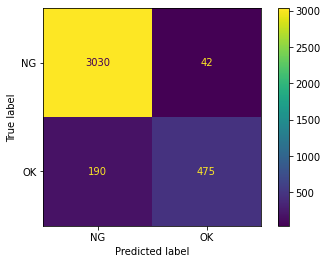

In [ ]:
#chose best hyperparameters

classifier_NB = MultinomialNB(alpha=0.5)
classifier_NB.fit(vectors, y_train)
predictions = classifier_NB.predict(vectors_test)
accuracy_score = metrics.accuracy_score(y_test, 
                                        predictions)

print("Accuracy score: ", accuracy_score)

#no indication for overfitting
cvacc = cross_val_score(classifier_NB, X=vectors,  y=y_train, cv=5, scoring='accuracy')
print('Acc. 5-fold cross on train data= ', cvacc.mean())

print(classification_report(y_test, predictions))
ConfusionMatrixDisplay.from_estimator(classifier_NB, vectors_test, y_test)

In [ ]:
#predict labels for 'data_to_predict['cleaned']'

vectors_test_eval_NB = vectorizer.transform(data_to_predict['cleaned'])
predictions_test_eval_NB = classifier_NB.predict(vectors_test_eval_NB)
print(predictions_test_eval_NB)

['NG' 'NG' 'NG' ... 'OK' 'NG' 'NG']


## SVC

In [ ]:
#superior accuracy with l1
#C*= 1
#CountVectorizer: similar performance
#vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS) 
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", sublinear_tf=True)

vectors = vectorizer.fit_transform(X_train)

classifier = LinearSVC(C=1, penalty='l1', max_iter=2000, dual=False)
classifier.fit(vectors, y_train)

vectors_test = vectorizer.transform(X_test)

#no indication for overfitting
cvacc = cross_val_score(classifier, X=vectors,  y=y_train, cv=5, scoring='accuracy')
print('Acc. 5-fold cross on train data= ', cvacc.mean())

print(classification_report(y_test, classifier.predict(vectors_test)))

Acc. 5-fold cross on train data=  0.9647373703579791
              precision    recall  f1-score   support

          NG       0.98      0.98      0.98      3072
          OK       0.91      0.89      0.90       665

    accuracy                           0.96      3737
   macro avg       0.94      0.94      0.94      3737
weighted avg       0.96      0.96      0.96      3737



### Hyperparameter tuning

In [ ]:
params_SVC = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']}

svc_grid = GridSearchCV(SVC(), param_grid=params_SVC, cv=3, refit = True, verbose = 3)
svc_grid.fit(vectors,y_train)
print('Best Parameters : ',svc_grid.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.823 total time=  11.9s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.822 total time=  12.0s
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.823 total time=  11.8s
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.830 total time=   7.3s
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.827 total time=   7.4s
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.829 total time=   7.3s
[CV 1/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.822 total time=  20.3s
[CV 2/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.822 total time=  20.9s
[CV 3/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.823 total time=  20.6s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.822 total time=   9.0s
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.822 total time=   9.0s
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf

Acc. 5-fold cross on train data=  0.9579792572766813
              precision    recall  f1-score   support

          NG       0.98      0.98      0.98      3072
          OK       0.90      0.88      0.89       665

    accuracy                           0.96      3737
   macro avg       0.94      0.93      0.93      3737
weighted avg       0.96      0.96      0.96      3737



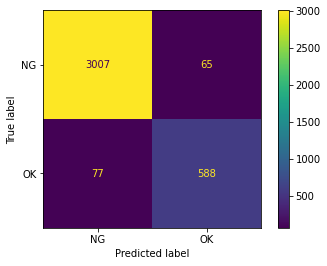

In [ ]:
classifier_SVC = SVC(C=1, gamma=1, kernel='linear')
classifier_SVC.fit(vectors, y_train)

cvacc = cross_val_score(classifier_SVC, X=vectors,  y=y_train, cv=5, scoring='accuracy')
print('Acc. 5-fold cross on train data= ', cvacc.mean())

print(classification_report(y_test, classifier_SVC.predict(vectors_test)))

ConfusionMatrixDisplay.from_estimator(classifier_SVC, vectors_test, y_test)

In [ ]:
#predict labels for 'data_to_predict['cleaned']'

vectors_test_eval_SVC = vectorizer.transform(data_to_predict['cleaned'])
predictions_test_eval_SVC = classifier_SVC.predict(vectors_test_eval_SVC)
print(predictions_test_eval_SVC)

['NG' 'NG' 'NG' ... 'OK' 'NG' 'NG']


## Neural Network

In [ ]:
#2mins runtime with max_iter=300, acc:0.9422
#same with max_iter=300
#TfidfVectorizer: acc:0.9376, f1:0.8848
#vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectors = vectorizer.fit_transform(X_train)

classifier = MLPClassifier(random_state=1, max_iter=300).fit(vectors, y_train)

vectors_test = vectorizer.transform(X_test)

predictions = classifier.predict(vectors_test)
accuracy_score = metrics.accuracy_score(y_test, 
                                        predictions)

print("Accuracy score: ", accuracy_score)
cvacc = cross_val_score(classifier, X=vectors,  y=y_train, cv=5, scoring='accuracy')
print('Acc. 5-fold cross on train data= ', cvacc.mean())

print(classification_report(y_test, predictions))


Accuracy score:  0.9408616537329408
Acc. 5-fold cross on train data=  0.9393777183004349
              precision    recall  f1-score   support

          NG       0.96      0.97      0.96      3072
          OK       0.86      0.80      0.83       665

    accuracy                           0.94      3737
   macro avg       0.91      0.89      0.90      3737
weighted avg       0.94      0.94      0.94      3737



### Hyperparameter tuning

In [ ]:
params_NN = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
nn_grid = GridSearchCV(MLPClassifier(random_state=1, max_iter=600), param_grid=params_NN, cv=3, refit = True, verbose = 3)
nn_grid.fit(vectors,y_train)
print('Best Parameters : ',nn_grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd;, score=0.957 total time=  50.9s
[CV 2/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd;, score=0.954 total time=  51.5s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd;, score=0.957 total time=  53.7s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.925 total time=  10.7s
[CV 2/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.927 total time=   8.6s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.939 total time=  10.0s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(5

Acc. 5-fold cross on train data=  0.9607895617263299
              precision    recall  f1-score   support

          NG       0.98      0.97      0.98      3072
          OK       0.88      0.93      0.90       665

    accuracy                           0.96      3737
   macro avg       0.93      0.95      0.94      3737
weighted avg       0.97      0.96      0.97      3737



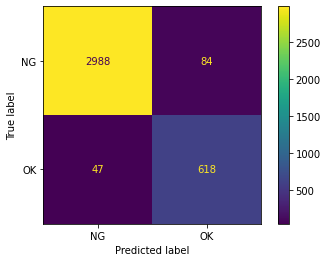

In [ ]:
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectors = vectorizer.fit_transform(X_train)
vectors_test = vectorizer.transform(X_test)

classifier_NN = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes= (100,), learning_rate='constant', solver='sgd', max_iter=500)
classifier_NN.fit(vectors, y_train)

cvacc = cross_val_score(classifier_NN, X=vectors,  y=y_train, cv=5, scoring='accuracy')
print('Acc. 5-fold cross on train data= ', cvacc.mean())

print(classification_report(y_test, classifier_NN.predict(vectors_test)))

ConfusionMatrixDisplay.from_estimator(classifier_NN, vectors_test, y_test)

In [ ]:
#predict labels for 'data_to_predict['cleaned']'

vectors_test_eval_NN = vectorizer.transform(data_to_predict['cleaned'])
predictions_test_eval_NN = classifier_NN.predict(vectors_test_eval_NN)
print(predictions_test_eval_NN)

['NG' 'NG' 'NG' ... 'OK' 'NG' 'NG']


## Export results

In [ ]:
data_to_predict['pred_NB'] = predictions_test_eval_NB
data_to_predict['pred_SVC'] = predictions_test_eval_SVC
data_to_predict['pred_NN'] = predictions_test_eval_NN

#data_to_predict.info()
#data_to_predict.head()
#data_to_predict.to_csv('test_predictions_all_methods.tsv', sep='\t')
data_to_predict_filtered_to_indecisiveness = data_to_predict[~((data_to_predict.pred_NB == 'NG') & (data_to_predict.pred_SVC == 'NG') & (data_to_predict.pred_NN == 'NG')) & ~((data_to_predict.pred_NB == 'OK') & (data_to_predict.pred_SVC == 'OK') & (data_to_predict.pred_NN == 'OK'))]
data_to_predict_filtered_to_indecisiveness.info()
data_to_predict_filtered_to_indecisiveness.head()
#data_to_predict_filtered_to_indecisiveness.to_csv('test_predictions_filtered_to_indecisiveness.tsv', sep='\t')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 12 to 4661
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      310 non-null    object
 1   label     310 non-null    object
 2   pred_NB   310 non-null    object
 3   pred_SVC  310 non-null    object
 4   pred_NN   310 non-null    object
dtypes: object(5)
memory usage: 14.5+ KB


In [ ]:
data_to_predict.label = data_to_predict.pred_SVC

data_to_predict = data_to_predict.drop(columns='text_custom_cleaned')
data_to_predict = data_to_predict.drop(columns='cleaned')
data_to_predict = data_to_predict.drop(columns='pred_NB')
data_to_predict = data_to_predict.drop(columns='pred_SVC')
data_to_predict = data_to_predict.drop(columns='pred_NN')

print(data_to_predict)
data_to_predict.to_csv('test_predictions.tsv', sep='\t')

                                                   text label
0     Niggas cry when they get hit high and cry when...    NG
1     RT @USER: Boss Niggas Fuk wit Boss bitches Vic...    NG
2     Notice I didn't tweet "bytches".... Bytch is d...    NG
3                             @USER @USER fuck up pussy    NG
4     @USER i swear u a fuck nigga u a scary little ...    NG
...                                                 ...   ...
4666  “@USER: Malibus on a come-up but in other news...    NG
4667  Hate when bitches get boyfriends then forget a...    NG
4668  #ExplainAnAnimePlotBadly Boy with a monkey tai...    OK
4669  Crying to the G20 that some Americans don't li...    NG
4670  RT @USER: I done had EVERYTHING you hoes ever ...    NG

[4671 rows x 2 columns]
